# Il problema

La competizione Nomad2018 richiedeva di predire l'energia di formazione e il gap di banda di una classe di semiconduttori trasparenti, composti di alluminio, gallio e indio, sulla base loro composizione percentuale e della loro struttura reticolare. Venivano forniti separatamente l'insieme di addestramento e l'insieme di test; in quest'ultimo però mancano i dati sull'energia di formazione e sul gap di banda, coerentemente con lo scopo del concorso. Ci si concentra perciò solo sul dataset di test originario ('test.csv') e si usa circa l'$80\%$  dei dati lì presenti per addestrare il modello e i rimanenti per testarlo. Nell'addestramento è inclusa la scelta degli iperparametri (validazione): la $\textit{grid search}$ implementata si basa sulla validazione incrociata dei diversi modelli addestrati con diversi valori degli iperparametri, per sceglierne i migliori.


I dati forniti sono:
- $\texttt{spacegroup}$: gruppo di simmetria a cui appartiene il materiale in questione. 
- $\texttt{number_of_total_atoms}$: numero totale di atomi per cella.
- $\texttt{percent_atom_al}, \texttt{percent_atom_ga}, \texttt{percent_atom_in}$: frazione di alluminio, gallio e indio.
- $\texttt{lattice_vector_1_ang}$, $\texttt{lattice_vector_2_ang}$, $\texttt{lattice_vector_3_ang}$, $\texttt{lattice_angle_alpha_degree}$, $\texttt{lattice_angle_beta_degree}$, $\texttt{lattice_angle_gamma_degree}$: lunghezza dei vettori reticolari (in &Aring;) e angoli (in &deg;) che ne determinano la struttura.

Sotto è mostrata la distribuzione dei dati per caratteristica.

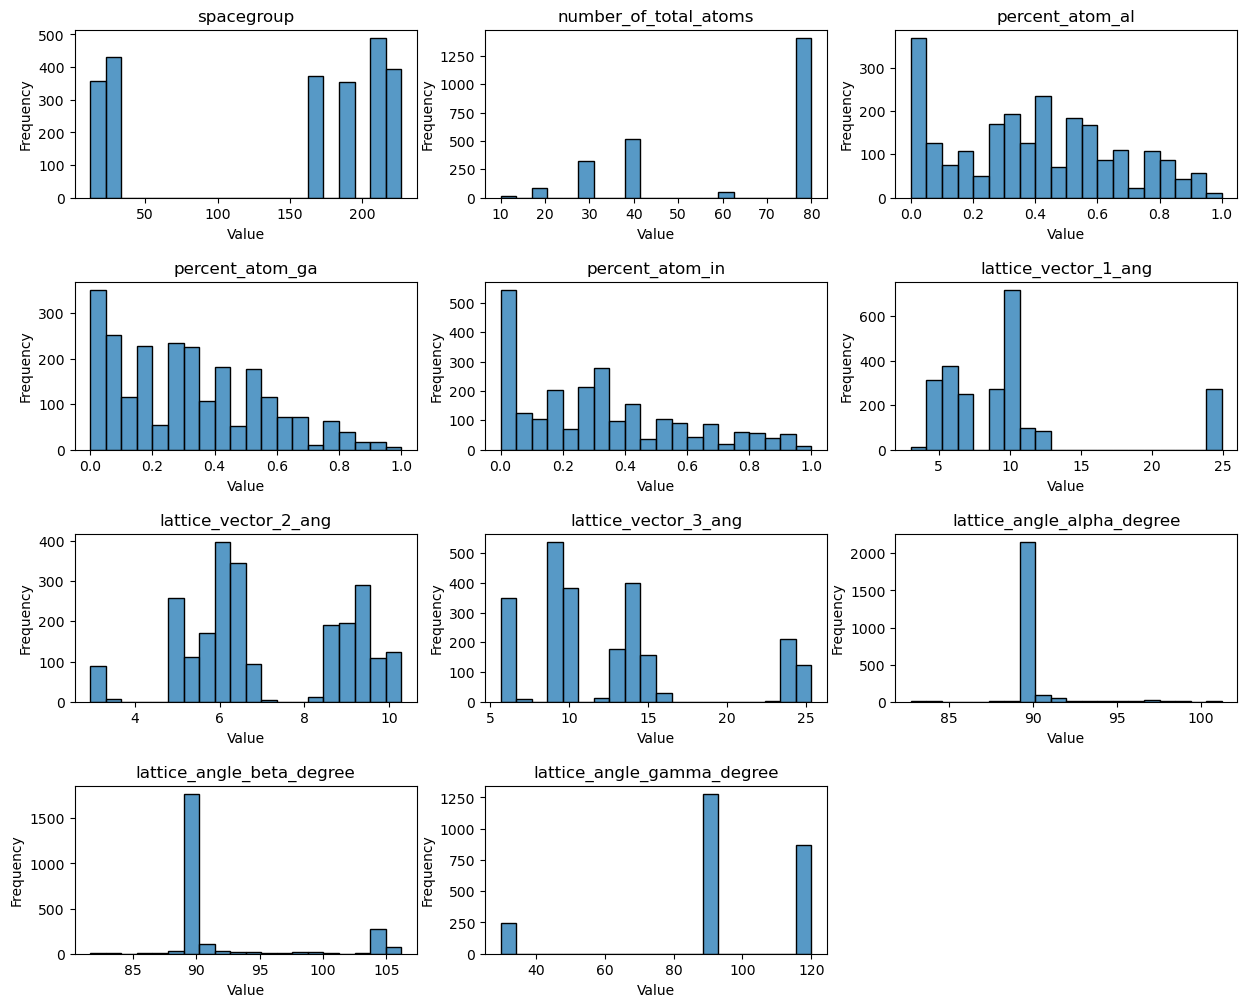

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

data = pd.read_csv('train.csv')

X = data.drop((['id', 'formation_energy_ev_natom', 'bandgap_energy_ev']), axis = 1)
y = data[['formation_energy_ev_natom', 'bandgap_energy_ev']]



# Ripartizione degli istogrammi
subplots_per_row = 3
num_features = len(X.columns)
num_rows = (num_features - 1) // subplots_per_row + 1


fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(15, 3*num_rows))
fig.subplots_adjust(hspace=0.5) 


axes = axes.flatten() # Necessario se gli istogrammi occupano una sola riga

for i, feature in enumerate(X.columns):
    ax = axes[i]
    sns.histplot(X[feature], ax=ax, kde=False, bins=20) 
    ax.set_title(feature)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

# Nasconde gli istogrammi vuoti
for i in range(num_features, len(axes)):
    axes[i].axis('off')
    

plt.show()

<AxesSubplot:>

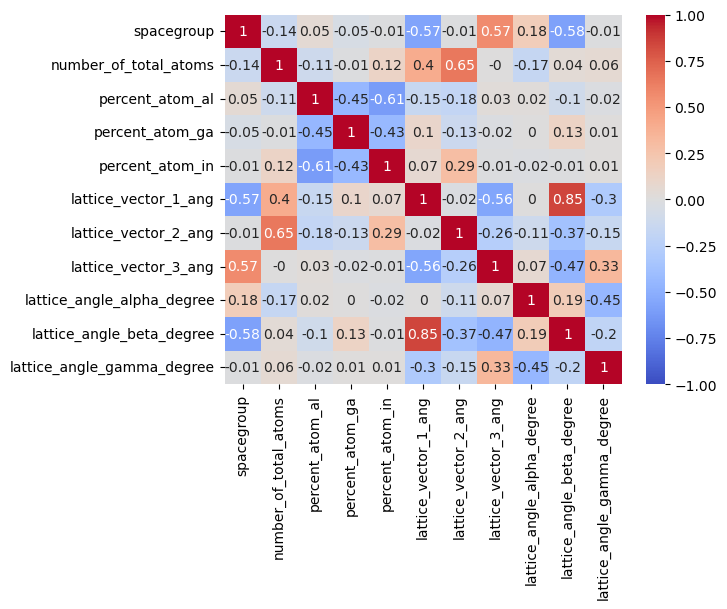

In [2]:
# Calcolo della matrice di correlazione tra le caratteristiche
correlation_matrix = X.corr().round(2)
sns.heatmap(data=correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=True)

Non si riscontrano correlazioni significative nell'insieme delle caratteristiche. Considerando anche che queste sono facilmente gestibili da un punto di vista computazionale ($p = 11$) non sembra opportuno applicare tecniche di riduzione della dimensionalità.

# Preelaborazione dei dati

Dal momento che i valori numerici che identificano i gruppi di simmetria (6 in totale) non hanno significato in quanto tali, né ha senso misurare la loro distanza reciproca, si preferisce trattare questa caratteristica come un'etichetta, codificandola con un vettore $\textit{one-hot}$. Alle altre caratteristiche si applica invece lo $\textit{standard scaling}$, che consiste nel sottrare ai dati la loro media e dividere il risultato per la varianza. Questo perché la regressione $\textit{ridge}$ (si veda sotto) non è invariante per trasformazioni di scala, dal momento che impone una penalità alla norma-2 dei coefficienti.

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Divisione tra caratteristiche numeriche e categoriali
categorical_columns = ['spacegroup'] 
numeric_columns = X.columns.difference(categorical_columns)


preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_scaler', StandardScaler(), numeric_columns),
        ('categorical_encoder', OneHotEncoder(), categorical_columns)
    ],
)

# Preelaborazione
X = preprocessor.fit_transform(X)


# Divisione in insieme di addestramento e insieme di test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# I modelli

Si preferisce implementare due regressioni separate, una per ciascun target, piuttosto che una regressione multivariata perché questo permette di scegliere separatamente gli iperparametri ottimali.
Le regressioni sono effettuate con kernel di Mercer e regolarizzazione ridge.

### Kernel

Per rendere più espressivo un modello lineare è possibile sostituire le caratteristiche originali con loro funzioni (dette caratteristiche generalizzate) che le combinano e le trasformano non linearmente. Ne risulta un modello altrettanto semplice (perché è pur sempre lineare nelle caratteristiche generalizzate), ma molto più versatile: vive infatti nello span delle funzioni scelte, che peraltro possono crescere indefinitamente in numero. 
D'altra parte il teorema di Mercer affema che ogni kernel $K(\underline{x}, \underline{x}')$ - funzione simmetrica a valori reali di due variabili vettoriali - definito positivo ammette un'espansione in termini di funzioni di una sola variabile vettoriale $\{\phi_i\}$, che possono essere identificate con le caratteristiche generalizzate:

$$ K(\underline{x}, \underline{x}') =  \sum_i \phi_i(\underline{x}) \phi_i(\underline{x}').$$

Anziché scegliere direttmente un insieme di caratteristiche generalizzate, si può cambiare prospettiva e scegliere un kernel la cui espansione contenga tali caratteristiche: a questo punto il modello originale (quello lineare, nel nostro caso) si generalizza in modo semplice e computazionalmente efficiente sostituendo i prodotti scalari nello spazio delle caratteristiche $\underline{x}^T \underline{x}'$ con chiamate alla funzione di kernel $K(\underline{x}, \underline{x}')$ che come detto fornisce un risultato equivalente al prodotto scalare nello spazio delle caratteristiche generalizzate. Tale pratica va sotto il nome di $\textit{kernel trick}$.

In questo progetto sono stati utilizzati il kernel polinomiale:

$$ K(\underline{x}, \underline{x}') = \left( 1 +  \frac{1}{N} \underline{x}^T \underline{x}' \right)^d,$$ 

che si espande in termini dei polinomi di grado pari o inferiore a $d$; e il kernel gaussiano isotropo, o kernel rbf (da radial basis function):

$$ K(\underline{x}, \underline{x}') = \exp\left( - \gamma \|\underline{x} - \underline{x}' \|^2 \right),$$

la cui espansione contiene i polinomi di tutti gli ordini.




### Regolarizzazione ridge

La regolarizzazione ridge impone una penalità al modulo quadro dei coefficienti della regressione (fatta eccezione per l'intercetta) aggiungendo un termine proporzionale alla norma-2 del vettore dei coefficienti alla funzione di costo, tipicamente la media degli scarti quadratici:

$$ C(\underline{\theta}) = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}(\underline{x}_i) - y_i)^2 + \frac{\lambda}{N}  \| \underline{\theta} \| ^2 $$

L'iperparametro $\lambda$ (detto $\alpha$ nella libreria Scikit-learn) controlla l'intensità dello $\textit{shrinkage}$, cioè della tendenza a ridurre il modulo dei parametri del modello. Nei modelli lineari con kernel si utilizza spesso la regolarizzazione ridge perché si presta ad essere "kernelizzata", ossia vi si può applicare il kernel trick, al prezzo di invertire una matrice $N \times N$.

In [4]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

# Valori degli iperparametri
alphas = np.logspace(-6, 3, 30)
gammas = np.logspace(-6, 3, 30)
ds = np.linspace(1, 10, 10)

parameters_rbf = {'kernel':['rbf'], 'alpha':alphas, 'gamma':gammas}
parameters_poly = {'kernel':['poly'], 'alpha':alphas, 'degree':ds}


# Divisione dei target
y1_train = y_train['formation_energy_ev_natom']
y2_train = y_train['bandgap_energy_ev']

y1_test = y_test['formation_energy_ev_natom']
y2_test = y_test['bandgap_energy_ev']

### Selezione e addestramento dei modelli, risultati della validazione incrociata

In [5]:
# Model 1, rbf
model1_rbf = GridSearchCV(KernelRidge(), parameters_rbf, scoring='neg_mean_squared_error')
model1_rbf.fit(X_train, y1_train)

GridSearchCV(estimator=KernelRidge(),
             param_grid={'alpha': array([1.00000000e-06, 2.04335972e-06, 4.17531894e-06, 8.53167852e-06,
       1.74332882e-05, 3.56224789e-05, 7.27895384e-05, 1.48735211e-04,
       3.03919538e-04, 6.21016942e-04, 1.26896100e-03, 2.59294380e-03,
       5.29831691e-03, 1.08263673e-02, 2.21221629e-02, 4.52035366e-02,
       9.23670857e-02, 1.88739182e-01, 3.85662042e-01, 7...
       3.03919538e-04, 6.21016942e-04, 1.26896100e-03, 2.59294380e-03,
       5.29831691e-03, 1.08263673e-02, 2.21221629e-02, 4.52035366e-02,
       9.23670857e-02, 1.88739182e-01, 3.85662042e-01, 7.88046282e-01,
       1.61026203e+00, 3.29034456e+00, 6.72335754e+00, 1.37382380e+01,
       2.80721620e+01, 5.73615251e+01, 1.17210230e+02, 2.39502662e+02,
       4.89390092e+02, 1.00000000e+03]),
                         'kernel': ['rbf']},
             scoring='neg_mean_squared_error')

In [6]:
cv_results1_rbf = pd.DataFrame(model1_rbf.cv_results_)
cv_results1_rbf[cv_results1_rbf['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
434,0.055395,0.002085,0.005748,0.00055,0.022122,0.022122,rbf,"{'alpha': 0.022122162910704502, 'gamma': 0.022...",-0.00216,-0.001566,-0.001789,-0.002299,-0.001966,-0.001956,0.000261,1


In [7]:
# Model 1, poly
model1_poly = GridSearchCV(KernelRidge(), parameters_poly, scoring='neg_mean_squared_error')
model1_poly.fit(X_train, y1_train)

GridSearchCV(estimator=KernelRidge(),
             param_grid={'alpha': array([1.00000000e-06, 2.04335972e-06, 4.17531894e-06, 8.53167852e-06,
       1.74332882e-05, 3.56224789e-05, 7.27895384e-05, 1.48735211e-04,
       3.03919538e-04, 6.21016942e-04, 1.26896100e-03, 2.59294380e-03,
       5.29831691e-03, 1.08263673e-02, 2.21221629e-02, 4.52035366e-02,
       9.23670857e-02, 1.88739182e-01, 3.85662042e-01, 7.88046282e-01,
       1.61026203e+00, 3.29034456e+00, 6.72335754e+00, 1.37382380e+01,
       2.80721620e+01, 5.73615251e+01, 1.17210230e+02, 2.39502662e+02,
       4.89390092e+02, 1.00000000e+03]),
                         'degree': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
                         'kernel': ['poly']},
             scoring='neg_mean_squared_error')

In [8]:
cv_results1_poly = pd.DataFrame(model1_poly.cv_results_)
cv_results1_poly[cv_results1_poly['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_degree,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
213,0.07518,0.00188,0.012111,0.000815,3.290345,4.0,poly,"{'alpha': 3.2903445623126713, 'degree': 4.0, '...",-0.002232,-0.001503,-0.001872,-0.002251,-0.001971,-0.001966,0.000274,1


In [9]:
# Model 2, rbf
model2_rbf = GridSearchCV(KernelRidge(), parameters_rbf, scoring='neg_mean_squared_error')
model2_rbf.fit(X_train, y2_train)

GridSearchCV(estimator=KernelRidge(),
             param_grid={'alpha': array([1.00000000e-06, 2.04335972e-06, 4.17531894e-06, 8.53167852e-06,
       1.74332882e-05, 3.56224789e-05, 7.27895384e-05, 1.48735211e-04,
       3.03919538e-04, 6.21016942e-04, 1.26896100e-03, 2.59294380e-03,
       5.29831691e-03, 1.08263673e-02, 2.21221629e-02, 4.52035366e-02,
       9.23670857e-02, 1.88739182e-01, 3.85662042e-01, 7...
       3.03919538e-04, 6.21016942e-04, 1.26896100e-03, 2.59294380e-03,
       5.29831691e-03, 1.08263673e-02, 2.21221629e-02, 4.52035366e-02,
       9.23670857e-02, 1.88739182e-01, 3.85662042e-01, 7.88046282e-01,
       1.61026203e+00, 3.29034456e+00, 6.72335754e+00, 1.37382380e+01,
       2.80721620e+01, 5.73615251e+01, 1.17210230e+02, 2.39502662e+02,
       4.89390092e+02, 1.00000000e+03]),
                         'kernel': ['rbf']},
             scoring='neg_mean_squared_error')

In [10]:
cv_results2_rbf = pd.DataFrame(model2_rbf.cv_results_)
cv_results2_rbf[cv_results2_rbf['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
222,0.046281,0.001061,0.004874,0.000592,0.000149,0.005298,rbf,"{'alpha': 0.00014873521072935117, 'gamma': 0.0...",-0.053729,-0.043467,-0.04735,-0.052478,-0.046576,-0.04872,0.003828,1


In [11]:
# Model 2, poly
model2_poly = GridSearchCV(KernelRidge(), parameters_poly, scoring='neg_mean_squared_error')
model2_poly.fit(X_train, y2_train)

GridSearchCV(estimator=KernelRidge(),
             param_grid={'alpha': array([1.00000000e-06, 2.04335972e-06, 4.17531894e-06, 8.53167852e-06,
       1.74332882e-05, 3.56224789e-05, 7.27895384e-05, 1.48735211e-04,
       3.03919538e-04, 6.21016942e-04, 1.26896100e-03, 2.59294380e-03,
       5.29831691e-03, 1.08263673e-02, 2.21221629e-02, 4.52035366e-02,
       9.23670857e-02, 1.88739182e-01, 3.85662042e-01, 7.88046282e-01,
       1.61026203e+00, 3.29034456e+00, 6.72335754e+00, 1.37382380e+01,
       2.80721620e+01, 5.73615251e+01, 1.17210230e+02, 2.39502662e+02,
       4.89390092e+02, 1.00000000e+03]),
                         'degree': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
                         'kernel': ['poly']},
             scoring='neg_mean_squared_error')

In [12]:
cv_results2_poly = pd.DataFrame(model2_poly.cv_results_)
cv_results2_poly[cv_results2_poly['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_degree,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
203,0.072222,0.000945,0.012099,0.0005,1.610262,4.0,poly,"{'alpha': 1.6102620275609392, 'degree': 4.0, '...",-0.054883,-0.042391,-0.048039,-0.053719,-0.046004,-0.049007,0.0047,1


# Risultati

In [13]:
# Valori migliori degli iperparametri

print('Energia di formazione: ', model1_rbf.best_params_)
print('Energia di formazione: ', model1_poly.best_params_)
print('Gap di banda: ', model2_rbf.best_params_)
print('Gap di banda: ', model2_poly.best_params_)

Energia di formazione:  {'alpha': 0.022122162910704502, 'gamma': 0.022122162910704502, 'kernel': 'rbf'}
Energia di formazione:  {'alpha': 3.2903445623126713, 'degree': 4.0, 'kernel': 'poly'}
Gap di banda:  {'alpha': 0.00014873521072935117, 'gamma': 0.005298316906283713, 'kernel': 'rbf'}
Gap di banda:  {'alpha': 1.6102620275609392, 'degree': 4.0, 'kernel': 'poly'}


In [14]:
# Test score

# Scikit-learn massimizza la funzione di scoring, perciò occorre cambiare di segno gli score
score1_rbf = -1.*model1_rbf.score(X_test, y1_test)
score1_poly = -1.*model1_poly.score(X_test, y1_test)
score2_rbf = -1.*model2_rbf.score(X_test, y2_test)
score2_poly = -1.*model2_poly.score(X_test, y2_test)

print('Energia di formazione, rbf: ', score1_rbf)
print('Energia di formazione, poly: ', score1_poly)
print('Gap di banda, rbf: ', score2_rbf)
print('Gap di banda, poly: ', score2_poly)

Energia di formazione, rbf:  0.0018710628528440705
Energia di formazione, poly:  0.001963246042222694
Gap di banda, rbf:  0.046975528164070184
Gap di banda, poly:  0.04754330225580318


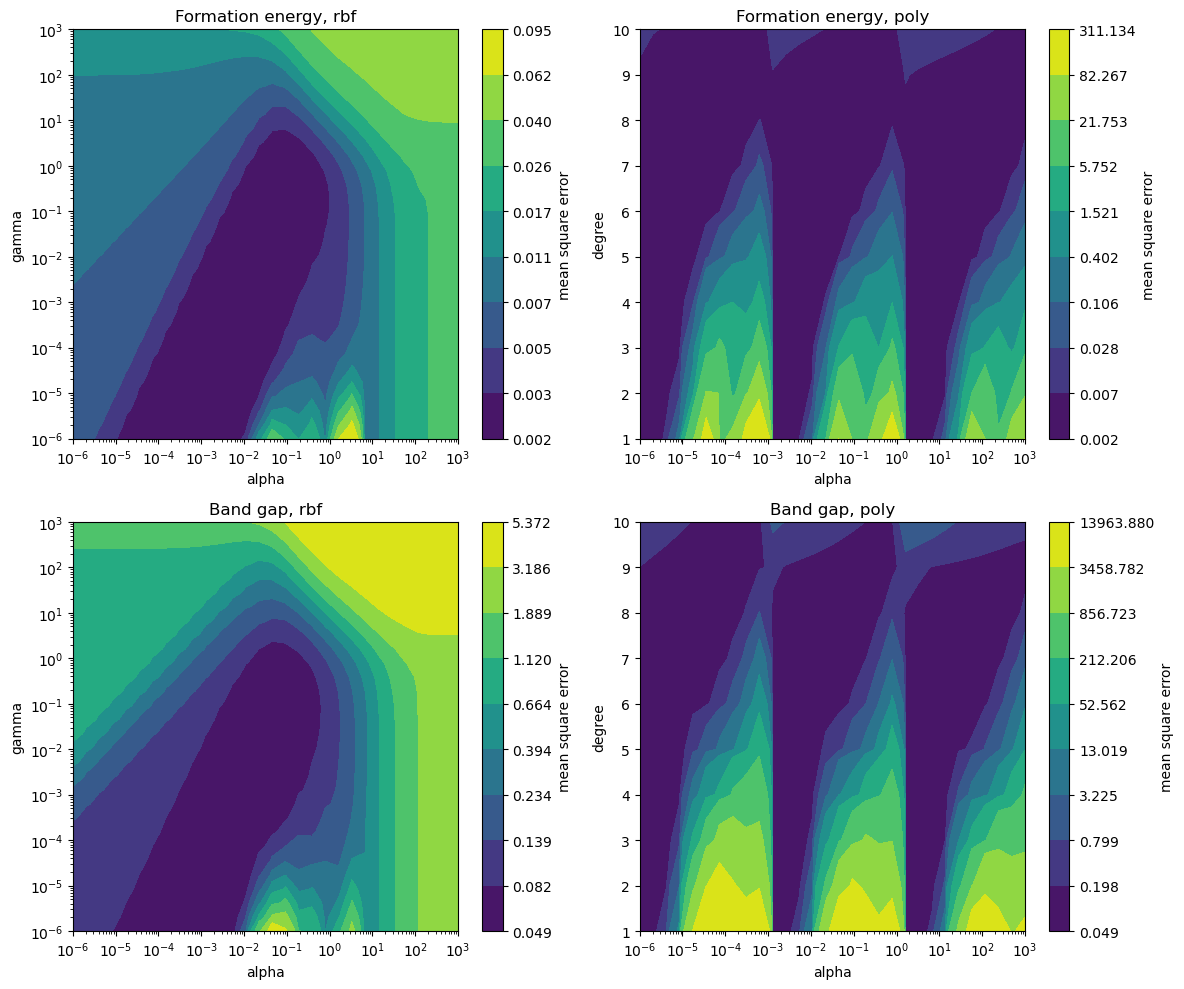

In [15]:
# Grafici di livello dello score in funzione degli iperparametri

from matplotlib.colors import LogNorm


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

models = [model1_rbf, model1_poly, model2_rbf, model2_poly]
kernels = ['rbf', 'poly', 'rbf', 'poly']


for i, (model, kernel) in enumerate(zip(models, kernels)):

    alpha_grid, gamma_grid = np.meshgrid(alphas, gammas) if kernel == 'rbf' else np.meshgrid(alphas, ds)
    mean_test_scores = np.reshape(-1. * model.cv_results_['mean_test_score'], (len(gammas) if kernel == 'rbf' else len(ds), -1))

    # Numero livelli nel grafico
    num_levels = 10
    contour_levels = np.logspace(np.log10(np.min(mean_test_scores)), np.log10(np.max(mean_test_scores)), num_levels)

    # Grafico di livello
    contour = axes[i].contourf(alpha_grid, gamma_grid, mean_test_scores, cmap='viridis', norm=LogNorm(), levels=contour_levels)

    axes[i].set_xlabel('alpha')
    axes[i].set_ylabel('gamma' if kernel == 'rbf' else 'degree')
    axes[i].set_xscale('log')
    if kernel == 'rbf':
        axes[i].set_yscale('log')

    cbar = fig.colorbar(contour, ax=axes[i], label='mean square error', format='%.3f')
    
    title = ('Formation energy, ' if i < 2 else 'Band gap, ') + kernel
    axes[i].set_title(title)

plt.tight_layout()
plt.show()

Sopra sono mostrati i grafici di livello dello score del modello calcolato sull'insieme di addestramaento con validazione incrociata ($5$-fold), in funzione dei valori degli iperparametri. È ragionevole aspettarsi che i modelli con kernel rbf e con kernel polinomiale generalizzino in modo simile all'insieme di test.

In [16]:
# DataFrame per i risultati
results = pd.DataFrame(y_test)

targets = ['1', '1', '2', '2']

for i, (model, kernel, target) in enumerate(zip(models, kernels, targets)):
    results['y'+target+'_'+kernel+'_pred'] = model.predict(X_test)
    results['residuals'+target+'_'+kernel] = abs(results['y'+target+'_'+kernel+'_pred'] - results['formation_energy_ev_natom' if target == '1' else 'bandgap_energy_ev'])
    
    print(results)

      formation_energy_ev_natom  bandgap_energy_ev  y1_rbf_pred  \
1950                     0.2438             1.9329     0.258512   
252                      0.2230             1.8181     0.258996   
1936                     0.0915             4.3484     0.104197   
1664                     0.0400             2.9940     0.047075   
398                      0.4294             0.8564     0.385104   
...                         ...                ...          ...   
2029                     0.2646             1.9311     0.254769   
359                      0.2698             0.8871     0.290102   
369                      0.0714             3.3925     0.068463   
309                      0.2006             2.5656     0.209006   
1632                     0.1336             1.4260     0.114674   

      residuals1_rbf  
1950        0.014712  
252         0.035996  
1936        0.012697  
1664        0.007075  
398         0.044296  
...              ...  
2029        0.009831  
359        

Per ciascun modello, le $n$ predizioni migliori e le $n$ predizioni peggiori ($n = 30$):

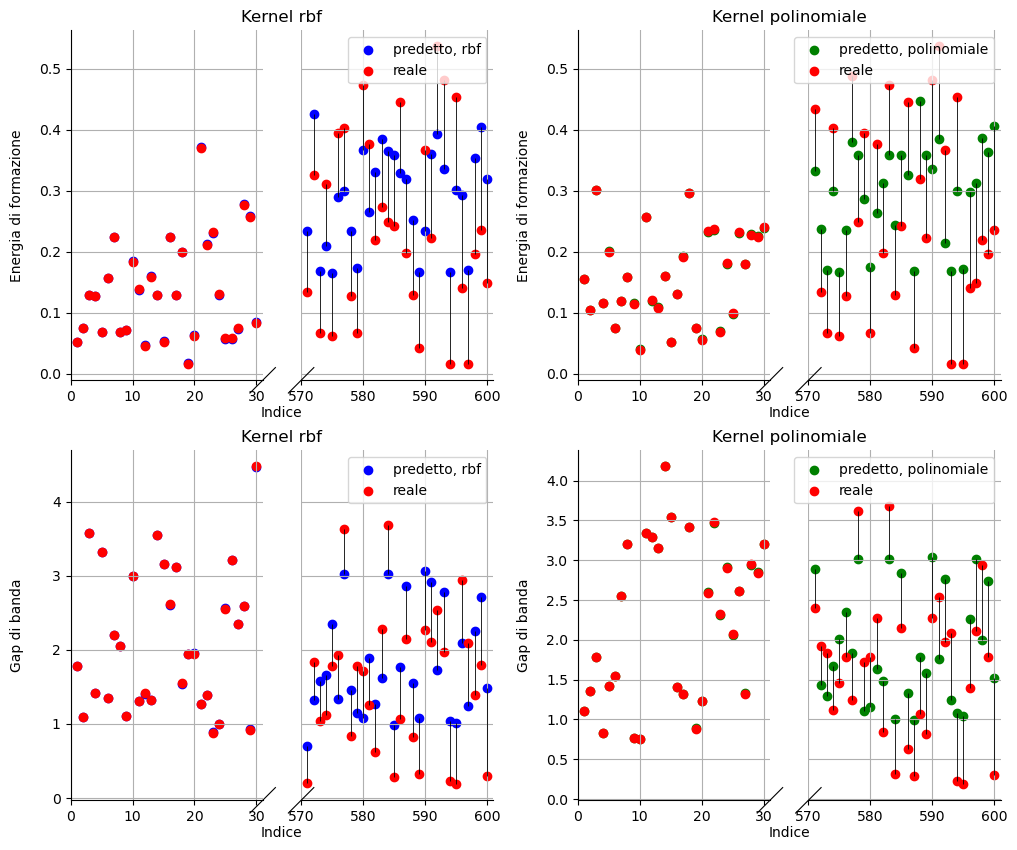

In [17]:
from brokenaxes import brokenaxes
from matplotlib.gridspec import GridSpec

n = 30
fig = plt.figure(figsize=(12, 10))
sps = GridSpec(2,2)


x_first_n = np.arange(1, n + 1)
x_last_n = len(y1_test) - (n-1) + np.arange(0, n)     

# DataFrame ordinati per residui
for i, (kernel, target) in enumerate(zip(kernels, targets)):
    sorted_results = results.sort_values(by='residuals'+target+'_'+kernel)
    
    x_first_n = np.arange(1, n + 1)
    x_last_n = len(y1_test) - (n-1) + np.arange(0, n)    
    
    bax = brokenaxes(xlims=((0, n+1), (len(y1_test) - n, len(y1_test) + 1)),
                 hspace=0.05, subplot_spec=sps[i])
    
    # Plot dei primi n punti
    bax.scatter(x_first_n, sorted_results['y'+target+'_'+kernel+'_pred'].head(n), 
                color=('blue' if kernel=='rbf' else 'green'), label=('predetto, '+('rbf' if kernel=='rbf' else 'polinomiale')))
    bax.scatter(x_first_n, sorted_results['formation_energy_ev_natom' if target=='1' else 'bandgap_energy_ev'].head(n), color='red', label='reale')
    
    # Plot degli ultimi n punti
    bax.scatter(x_last_n, sorted_results['y'+target+'_'+kernel+'_pred'].tail(n), color=('blue' if kernel=='rbf' else 'green'))
    bax.scatter(x_last_n, sorted_results['formation_energy_ev_natom' if target=='1' else 'bandgap_energy_ev'].tail(n), color='red')

    for j in range(0, n):
        x = len(y1_test)-n + j
        bax.vlines(x_last_n[j], sorted_results['y'+target+'_'+kernel+'_pred'].iloc[x], sorted_results['formation_energy_ev_natom' if target=='1' else 'bandgap_energy_ev'].iloc[x], 
                   color='black', linestyle='-', linewidth=0.6)

    bax.set_title('Kernel '+('rbf' if kernel=='rbf' else 'polinomiale'))
    bax.set_xlabel('Indice')
    bax.set_ylabel('Energia di formazione' if target=='1' else 'Gap di banda')
    bax.legend()

    bax.grid(True)

plt.show()
                                                                                                                   

### Metrica

È ragionevole per esempio usare come "metrica" l'errore assoluto, ossia il modulo della differenza tra valore vero e valore predetto (lunghezza dei segmenti verticali in figura), perché ha un'interpretazione "fisica" chiara. 

In [18]:
# Errore assoluto medio per i diversi modelli

print('Errori assoluti')
print('Energia di formazione, rbf: ', results['residuals1_rbf'].mean())
print('Energia di formazione, poly: ', results['residuals1_poly'].mean())
print('Gap di banda, rbf: ', results['residuals2_rbf'].mean())
print('Gap di banda, poly: ', results['residuals2_poly'].mean())

Errori assoluti
Energia di formazione, rbf:  0.028721039851004312
Energia di formazione, poly:  0.029253890231003343
Gap di banda, rbf:  0.13650149965082592
Gap di banda, poly:  0.1361787187547854


Da cui si può vedere ancora una volta che i modelli basati sul kernel rbf e sul kernel polinomiale generalizzano in modo molto simile. Gli errori relativi sono invece:

In [19]:
#Errore relativo medio per i diversi modelli

print('Errori relativi')
results['relerr1_rbf'] = results['residuals1_rbf']/results['formation_energy_ev_natom']
print('Energia di formazione, rbf: ', results['relerr1_rbf'].mean())

results['relerr1_poly'] = results['residuals1_poly']/results['formation_energy_ev_natom']
print('Energia di formazione, poly: ', results['relerr1_poly'].mean())

results['relerr2_rbf'] = results['residuals2_rbf']/results['bandgap_energy_ev']
print('Gap di banda, rbf: ', results['relerr2_rbf'].mean())

results['relerr2_poly'] = results['residuals2_poly']/results['bandgap_energy_ev']
print('Gap di banda, poly: ', results['relerr2_poly'].mean())

Errori relativi
Energia di formazione, rbf:  0.41476221088398013
Energia di formazione, poly:  0.415454139298639
Gap di banda, rbf:  0.26694462685571774
Gap di banda, poly:  0.23589210596634766


Si riscontrano valori così elevati a causa di pochi punti con variabile target molto piccola che il modello sbaglia a prevedere significativamente. Ad esempio:

In [20]:
print(results['relerr1_rbf'].max())

105.06408943624095


 Questo suggerisce che l'errore assoluto non ha una dipendenza forte dalla scala delle variabili target, cosa che può essere verificata graficando un $\textit{residual plot}$. Per esempio per il kernel rbf:

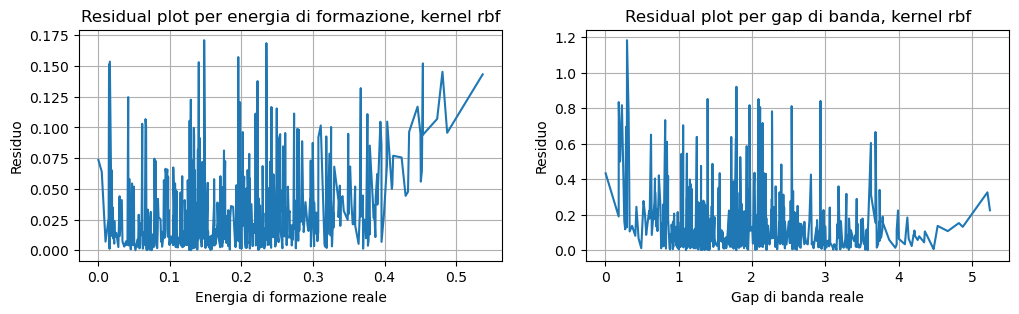

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes = axes.flatten()

sorted_results = results.sort_values(by='formation_energy_ev_natom')

axes[0].plot(sorted_results['formation_energy_ev_natom'], sorted_results['residuals1_rbf'])
axes[0].set_title('Residual plot per energia di formazione, kernel rbf')
axes[0].set_xlabel('Energia di formazione reale')
axes[0].set_ylabel('Residuo')
axes[0].grid(True)

sorted_results = results.sort_values(by='bandgap_energy_ev')

axes[1].plot(sorted_results['bandgap_energy_ev'], sorted_results['residuals2_rbf'])
axes[1].set_title('Residual plot per gap di banda, kernel rbf')
axes[1].set_xlabel('Gap di banda reale')
axes[1].set_ylabel('Residuo')
axes[1].grid(True)

plt.show()

Perciò è chiaro che l'errore relativo medio non costituisce un buon criterio per valutare il modello.

Si confrontano ora direttamente le previsioni dei modelli con kernel rbf e polinomiale. Dal momento che l'insieme di test contiene un numero elevato di dati ($600$ istanze), si grafica il confronto per i due target sul $10\%$ di tali istanze estratte casualmente.

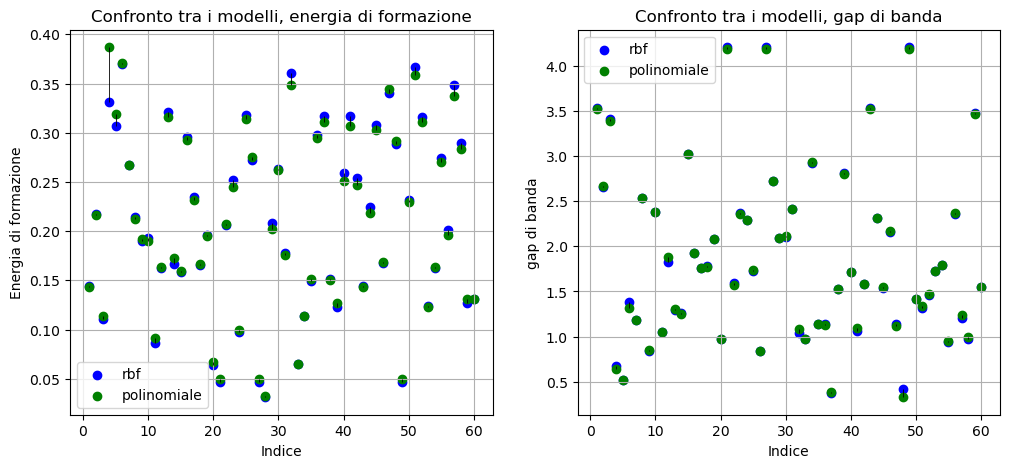

In [22]:
frac = 0.1

shuffled_results = results.sample(frac=frac, random_state=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

targets = ['1', '2']
for i, target in enumerate(targets):
    axes[i].scatter(np.arange(1, len(y1_test)*frac + 1), shuffled_results['y'+target+'_rbf_pred'], color='blue', label='rbf')
    axes[i].scatter(np.arange(1, len(y1_test)*frac + 1), shuffled_results['y'+target+'_poly_pred'], color='green', label='polinomiale')
    for j in range(0, int(len(y1_test)*frac)):
        axes[i].vlines(j+1, shuffled_results['y'+target+'_rbf_pred'].iloc[j], shuffled_results['y'+target+'_poly_pred'].iloc[j], 
                   color='black', linestyle='-', linewidth=0.6)
        
    axes[i].set_title('Confronto tra i modelli, '+('energia di formazione' if target=='1' else 'gap di banda'))
    axes[i].set_xlabel('Indice')
    axes[i].set_ylabel('Energia di formazione' if target=='1' else 'gap di banda')
    axes[i].grid(True)
    axes[i].legend()

plt.show()

L'accordo tra i due modelli è quasi perfetto in entrambi i casi: lo si può dimostrare anche quantitativamente prendendo in considerazione ancora la media del modulo degli scarti.

In [23]:
# Calcolo dello scarto medio tra le previsioni delle coppie di modelli

results['residuals_kernels_1'] = abs(results['y1_rbf_pred'] - results['y1_poly_pred'])
results['residuals_kernels_2'] = abs(results['y2_rbf_pred'] - results['y2_poly_pred'])

print('Media del modulo degli scarti tra le previsioni dei due modelli')
print('Energia di formazione:', results['residuals_kernels_1'].mean())
print('Gap di banda:', results['residuals_kernels_2'].mean())

Media del modulo degli scarti tra le previsioni dei due modelli
Energia di formazione: 0.0034222326471702756
Gap di banda: 0.01443434268356443


Queste sono almeno di un ordine di grandezza inferiori agli errori assoluti calcolati sopra, a significare che le previsioni dei modelli sono più simili tra loro che ai valori veri delle variabili di target. Perciò si può concludere che almeno su questo dataset la regressione con kernel gaussiano isotropo e regolarizzazione ridge e la regressione con kernel polinomiale e regolarizzazione ridge hanno un'espressività molto simile. Inoltre, come ci si può aspettare, anche il tempo di addestramento dei due modelli è comparabile, di poco inferiore per il kernel rbf.

Per scegliere e addestrare un modello migliore ci si potrebbe chiedere se i dati che i modelli utilizzati faticano a prevedere correttamente abbiano qualcosa in comune. Una strategia perseguibile è quella di utilizzare un algoritmo di apprendimento non supervisionato per dividere i dati in classi e studiare l'errore medio di queste.

# Referenze

Le fonti consultate per la realizzazione del progetto sono:
- Hastie et al., "The Elements of Statistical Learning"
- Geron, "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow"
- Note del corso